In [1]:
import warnings
import ipaddress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
tqdm.pandas()

## 1. Preprocessing the Data

In [4]:
df_2013 = pd.read_csv('combined_2013.csv', index_col=0)
df_2013['real_time_2013'] = pd.to_datetime(df_2013['real_time_2013'])
df_2013 = df_2013.sort_values('real_time_2013')
df_2013['is_up'] = (df_2013['reply_type_label_2013'] == 'responsive').astype(int)

In [5]:
df_2023 = pd.read_csv('combined_2023.csv', index_col=0)
df_2023['real_time_2023'] = pd.to_datetime(df_2023['real_time_2023'])
df_2023 = df_2023.sort_values('real_time_2023')
df_2023['is_up'] = (df_2023['reply_type_label_2023'] == 'responsive').astype(int)

In [6]:
df_2013

,time_s_2013,rtt_us_2013,ttl_2013,probe_addr_2013,reply_addr_2013,rtt_ms_2013,same_ip_2013,reply_type_label_2013,hop_count_2013,real_time_2013,first_octet,is_up
reply_type_2013,,,,,,,,,,,,
0x0000,1388107688,143746,112,128.208.92.12,128.208.92.12,143.746,True,responsive,16.0,2013-12-27 01:28:08,128,1
0x0800,1388107688,0,0,128.125.244.9,--------,0.000,False,no_response,NaN,2013-12-27 01:28:08,128,0
0x0800,1388107688,0,0,128.125.10.247,--------,0.000,False,no_response,NaN,2013-12-27 01:28:08,128,0
0x0800,1388107688,0,0,128.125.148.105,--------,0.000,False,no_response,NaN,2013-12-27 01:28:08,128,0
0x0800,1388107688,0,0,128.9.148.29,--------,0.000,False,no_response,NaN,2013-12-27 01:28:08,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...
0x0301,1388202727,323697,0,128.9.121.79,198.32.16.29,323.697,False,error,NaN,2013-12-28 03:52:07,128,0
0x0301,1388202727,323942,0,128.9.113.71,198.32.16.29,323.942,False,error,NaN,2013-12-28 03:52:07,128,0
0x0301,1388202727,324225,0,128.9.125.75,198.32.16.29,324.225,False,error,NaN,2013-12-28 03:52:07,128,0


## 2. Extracting Per-Address Metrics

In [7]:
def compute_metrics_generic(group, time_col):
    group = group.sort_values(time_col)
    times = group[time_col].dt.to_pydatetime().tolist()
    is_up = group['is_up'].values
    
    # 1. Availability: fraction of probes that were responsive.
    availability = is_up.mean()
    
    # 2. Volatility: count transitions from non-responsive to responsive.
    up_transitions = 0
    if len(is_up) > 0:
        if is_up[0] == 1:
            up_transitions += 1
        up_transitions += ((is_up[1:] == 1) & (is_up[:-1] == 0)).sum()
    
    # 3. Median Up Time: calculate the duration of each consecutive 'up' period.
    up_periods = []
    current_start = None
    for i, flag in enumerate(is_up):
        if flag == 1 and current_start is None:
            current_start = times[i]
        elif flag == 0 and current_start is not None:
            end_time = times[i - 1]
            duration = (end_time - current_start).total_seconds()
            up_periods.append(duration)
            current_start = None
    if current_start is not None:
        duration = (times[-1] - current_start).total_seconds()
        up_periods.append(duration)
    
    median_up = np.median(up_periods) if up_periods else 0
    
    return pd.Series({
        'availability': availability,
        'volatility': up_transitions,
        'median_up': median_up
    })

In [8]:
compute_metrics_2013 = partial(compute_metrics_generic, time_col='real_time_2013')
compute_metrics_2023 = partial(compute_metrics_generic, time_col='real_time_2023')

### 2013

In [9]:
metrics_2013 = df_2013.groupby('probe_addr_2013').progress_apply(compute_metrics_2013).reset_index()
print(metrics_2013.head())

100%|█████████████████████████████████| 174084/174084 [00:46<00:00, 3777.01it/s]

  probe_addr_2013  availability  volatility  median_up
0    128.0.63.180           0.0         0.0        0.0
1    128.0.63.212           0.0         0.0        0.0
2      128.0.63.4           0.0         0.0        0.0
3     128.0.63.52           0.0         0.0        0.0
4     128.0.90.17           0.0         0.0        0.0


### 2023

In [10]:
metrics_2023 = df_2023.groupby('probe_addr_2023').progress_apply(compute_metrics_2023).reset_index()
print(metrics_2023.head())

100%|█████████████████████████████████| 164606/164606 [00:42<00:00, 3903.32it/s]

  probe_addr_2023  availability  volatility  median_up
0     128.10.25.0      0.000000         0.0        0.0
1     128.10.25.1      0.992063         2.0    46530.0
2    128.10.25.10      0.000000         0.0        0.0
3   128.10.25.100      1.000000         1.0    94380.0
4   128.10.25.101      0.992063         2.0    46530.0


### Getting the csv

In [11]:
metrics_2013.to_csv('metrics_2013.csv', index=False)
metrics_2023.to_csv('metrics_2023.csv', index=False)

## 3. Grouping Addresses into Blocks

In [12]:
def extract_block(ip):
    return '.'.join(ip.split('.')[:3])

### 2013

In [13]:
metrics_2013 = pd.read_csv('metrics_2013.csv')

In [14]:
metrics_2013['block_24'] = metrics_2013['probe_addr_2013'].apply(extract_block)

In [15]:
block_metrics_2013 = metrics_2013.groupby('block_24').agg({
    'availability': 'median',
    'volatility': 'median',
    'median_up': 'median'
}).reset_index()

In [16]:
print("2013 /24 block metrics:")
print(block_metrics_2013.head())

2013 /24 block metrics:
      block_24  availability  volatility  median_up
0     128.0.63           0.0         0.0        0.0
1     128.0.90           0.0         0.0        0.0
2     128.0.94           0.0         0.0        0.0
3    128.10.25           0.0         0.0        0.0
4  128.100.210           0.0         0.0        0.0


### 2023

In [17]:
metrics_2023 = pd.read_csv('metrics_2023.csv')

In [18]:
metrics_2023['block_24'] = metrics_2023['probe_addr_2023'].apply(extract_block)

In [19]:
block_metrics_2023 = metrics_2023.groupby('block_24').agg({
    'availability': 'median',
    'volatility': 'median',
    'median_up': 'median'
}).reset_index()

In [20]:
print("2023 /24 block metrics:")
print(block_metrics_2023.head())

2023 /24 block metrics:
      block_24  availability  volatility  median_up
0    128.10.25           0.0         0.0        0.0
1  128.100.210           0.0         0.0        0.0
2   128.100.56           0.0         0.0        0.0
3   128.100.98           0.0         0.0        0.0
4  128.101.161           0.0         0.0        0.0


## 4. Block-Level Clustering (BlockSizeId)

In [21]:
def ip_to_int(ip_str):
    return int(ipaddress.IPv4Address(ip_str))

def block_size_id(df, current_prefix, epsilon=2.0):
    df = df.copy()
    df['ip_int'] = df['probe_addr'].apply(ip_to_int)
    df = df.sort_values('ip_int')
    
    overall_var = df[['availability', 'volatility', 'median_up']].var().sum()
    
    best_prefix = current_prefix
    best_var_sum = overall_var
    
    for p in range(current_prefix + 1, 33):
        sub_block_size = 2 ** (32 - p)
        base = df['ip_int'].min()
        df['sub_block'] = ((df['ip_int'] - base) // sub_block_size)
        
        var_sum = 0
        for _, group in df.groupby('sub_block'):
            var_sum += group[['availability', 'volatility', 'median_up']].var().sum()
        
        if best_var_sum - var_sum < epsilon:
            break
        else:
            best_var_sum = var_sum
            best_prefix = p

    if best_prefix == current_prefix:
        return [df]
    else:
        sub_block_size = 2 ** (32 - best_prefix)
        base = df['ip_int'].min()
        df['sub_block'] = ((df['ip_int'] - base) // sub_block_size)
        
        consistent_blocks = []
        for _, group in df.groupby('sub_block'):
            consistent_blocks.extend(block_size_id(group.copy(), best_prefix + 1, epsilon))
        return consistent_blocks

In [22]:
def process_all_blocks(metrics_df, ip_col, block_col='block_24', initial_prefix=24, epsilon=2.0):
    consistent_blocks_all = []
    unique_blocks = metrics_df[block_col].unique()
    
    for block_id in tqdm(unique_blocks, desc="Processing /24 blocks"):
        group = metrics_df[metrics_df[block_col] == block_id]
        sub_df = group.copy()
        sub_df = sub_df.rename(columns={ip_col: 'probe_addr'})
        consistent_blocks = block_size_id(sub_df, current_prefix=initial_prefix, epsilon=epsilon)
        for block in consistent_blocks:
            block_size = block.shape[0]
            block['final_block_size'] = block_size
            block['original_block'] = block_id
            consistent_blocks_all.append(block)
            
    return pd.concat(consistent_blocks_all, ignore_index=True)

### 2013

In [23]:
block_metrics_2013 = process_all_blocks(metrics_2013, ip_col='probe_addr_2013', block_col='block_24', initial_prefix=24, epsilon=2.0)
print("Processed consistent blocks for 2013:")
print(block_metrics_2013[['probe_addr', 'availability', 'median_up', 'original_block', 'final_block_size']].head())

Processing /24 blocks: 100%|███████████████| 1589/1589 [00:09<00:00, 175.77it/s]


Processed consistent blocks for 2013:
     probe_addr  availability  median_up original_block  final_block_size
0    128.0.63.4           0.0        0.0       128.0.63                 4
1   128.0.63.52           0.0        0.0       128.0.63                 4
2  128.0.63.180           0.0        0.0       128.0.63                 4
3  128.0.63.212           0.0        0.0       128.0.63                 4
4   128.0.90.17           0.0        0.0       128.0.90                 7


In [24]:
block_metrics_2013.to_csv('block_metrics_2013_new.csv', index=False)

### 2023

In [25]:
block_metrics_2023 = process_all_blocks(metrics_2023, ip_col='probe_addr_2023', block_col='block_24', initial_prefix=24, epsilon=2.0)
print("Processed consistent blocks for 2023:")
print(block_metrics_2023[['probe_addr', 'availability', 'volatility', 'median_up', 'original_block', 'final_block_size']].head())

Processing /24 blocks: 100%|█████████████████| 643/643 [00:03<00:00, 177.29it/s]

Processed consistent blocks for 2023:
    probe_addr  availability  volatility  median_up original_block  \
0  128.10.25.0      0.000000         0.0        0.0      128.10.25   
1  128.10.25.1      0.992063         2.0    46530.0      128.10.25   
2  128.10.25.2      0.000000         0.0        0.0      128.10.25   
3  128.10.25.3      0.000000         0.0        0.0      128.10.25   
4  128.10.25.4      0.000000         0.0        0.0      128.10.25   

   final_block_size  
0               256  
1               256  
2               256  
3               256  
4               256  


In [26]:
block_metrics_2023.to_csv('block_metrics_2023_new.csv', index=False)

### Comparison

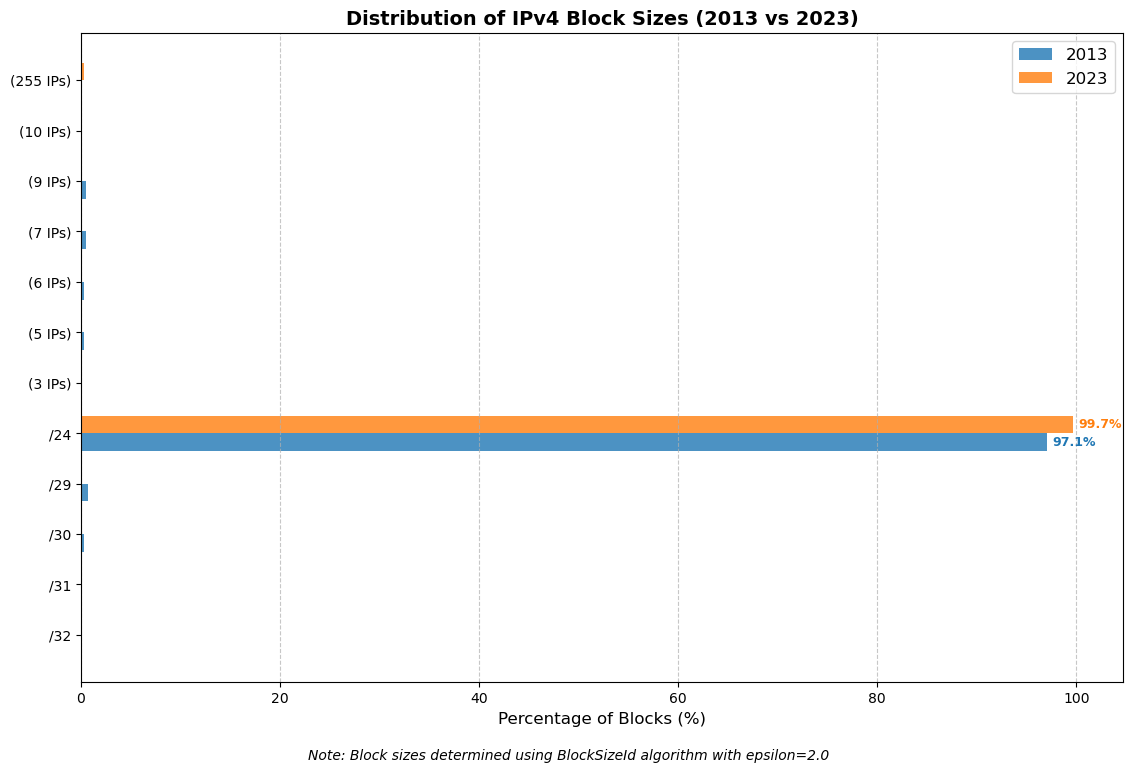


Block Size Statistics:
Total unique blocks in 2013: 1589
Total unique blocks in 2023: 643
Total consistent blocks identified in 2013: 11
Total consistent blocks identified in 2023: 2

Block Size Distribution:
         cidr  count_2013  percentage_2013  count_2023  percentage_2023
0         /32        86.0         0.049401         0.0         0.000000
1         /31       128.0         0.073528         0.0         0.000000
3         /30       476.0         0.273431         0.0         0.000000
7         /29      1232.0         0.707704         0.0         0.000000
11        /24    168960.0        97.056593    164096.0        99.690169
2     (3 IPs)       213.0         0.122355         0.0         0.000000
4     (5 IPs)       500.0         0.287218         0.0         0.000000
5     (6 IPs)       612.0         0.351554         0.0         0.000000
6     (7 IPs)       840.0         0.482526         0.0         0.000000
8     (9 IPs)       837.0         0.480802         0.0         0.00000

In [27]:
block_metrics_2013 = pd.read_csv('block_metrics_2013_new.csv')
block_metrics_2023 = pd.read_csv('block_metrics_2023_new.csv')

def block_size_to_cidr(size):
    if size == 1: return "/32"
    if size == 2: return "/31"
    if size == 4: return "/30"
    if size == 8: return "/29"
    if size == 16: return "/28"
    if size == 32: return "/27"
    if size == 64: return "/26"
    if size == 128: return "/25"
    if size == 256: return "/24"
    return f"({size} IPs)"

block_sizes_2013 = block_metrics_2013['final_block_size'].value_counts().reset_index()
block_sizes_2013.columns = ['block_size', 'count_2013']
block_sizes_2013['cidr'] = block_sizes_2013['block_size'].apply(block_size_to_cidr)
block_sizes_2013['percentage_2013'] = (block_sizes_2013['count_2013'] / block_sizes_2013['count_2013'].sum()) * 100

block_sizes_2023 = block_metrics_2023['final_block_size'].value_counts().reset_index()
block_sizes_2023.columns = ['block_size', 'count_2023']
block_sizes_2023['cidr'] = block_sizes_2023['block_size'].apply(block_size_to_cidr)
block_sizes_2023['percentage_2023'] = (block_sizes_2023['count_2023'] / block_sizes_2023['count_2023'].sum()) * 100

merged_sizes = pd.merge(block_sizes_2013, block_sizes_2023, on=['block_size', 'cidr'], how='outer').fillna(0)

standard_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
merged_sizes['is_standard'] = merged_sizes['block_size'].isin(standard_sizes)
merged_sizes = merged_sizes.sort_values(['is_standard', 'block_size'], ascending=[False, True])

sizes = merged_sizes['cidr'].tolist()
y_pos = np.arange(len(sizes))
percentages_2013 = merged_sizes['percentage_2013'].tolist()
percentages_2023 = merged_sizes['percentage_2023'].tolist()

plt.figure(figsize=(12, 8))

width = 0.35
plt.barh(y_pos - width/2, percentages_2013, width, label='2013', color='#1f77b4', alpha=0.8)
plt.barh(y_pos + width/2, percentages_2023, width, label='2023', color='#ff7f0e', alpha=0.8)

plt.xlabel('Percentage of Blocks (%)', fontsize=12)
plt.title('Distribution of IPv4 Block Sizes (2013 vs 2023)', fontsize=14, fontweight='bold')
plt.yticks(y_pos, sizes, fontsize=10)
plt.legend(loc='upper right', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(percentages_2013):
    if v > 1:
        plt.text(v + 0.5, i - width/2, f'{v:.1f}%', 
                 va='center', fontsize=9, color='#1f77b4', fontweight='bold')

for i, v in enumerate(percentages_2023):
    if v > 1:
        plt.text(v + 0.5, i + width/2, f'{v:.1f}%', 
                 va='center', fontsize=9, color='#ff7f0e', fontweight='bold')

plt.figtext(0.5, 0.01, 
            'Note: Block sizes determined using BlockSizeId algorithm with epsilon=2.0',
            ha='center', fontsize=10, style='italic')

plt.tight_layout(pad=3)
plt.show()

print("\nBlock Size Statistics:")
print(f"Total unique blocks in 2013: {block_metrics_2013['original_block'].nunique()}")
print(f"Total unique blocks in 2023: {block_metrics_2023['original_block'].nunique()}")
print(f"Total consistent blocks identified in 2013: {len(block_metrics_2013['final_block_size'].unique())}")
print(f"Total consistent blocks identified in 2023: {len(block_metrics_2023['final_block_size'].unique())}")

print("\nBlock Size Distribution:")
print(merged_sizes[['cidr', 'count_2013', 'percentage_2013', 'count_2023', 'percentage_2023']])

## 5. Ping-Observable Classification

### Not ML

In [28]:
def classify_block(row):
    alphaH = 0.95  # High availability threshold (95%)
    alphaL = 0.10  # Low availability threshold (10%)
    beta = 0.0016  # Low volatility threshold
    gamma = 6 * 3600  # 6 hours in seconds for median uptime

    # Always-stable: High availability (≥95%)
    if row['availability'] >= alphaH:
        return "Always-stable"

    # Sometimes-stable: High median-up time (≥6 hours), availability ≥10% but not meeting always-stable criteria
    if row['median_up'] >= gamma and row['availability'] >= alphaL:
        return "Sometimes-stable"

    # Intermittent: Low median-up time (<6 hours), availability ≥10% but not meeting always-stable criteria
    if row['median_up'] < gamma and row['availability'] >= alphaL:
        return "Intermittent"

    # Check if too few responses to classify confidently
    if row['availability'] == 0:
        return "Unclassifiable"
    
    # Underutilized: Low availability (<10%)
    if row['availability'] < alphaL:
        return "Underutilized"
    
    # Default case if none of the above conditions are met
    return "Unclassifiable"

### 2013

In [29]:
block_metrics_2013['ping_category'] = block_metrics_2013.apply(classify_block, axis=1)
print("Block-level ping-observable classification for 2013:")
print(block_metrics_2013[['block_24', 'availability', 'volatility', 'median_up', 'ping_category']].head())

Block-level ping-observable classification for 2013:
   block_24  availability  volatility  median_up   ping_category
0  128.0.63           0.0         0.0        0.0  Unclassifiable
1  128.0.63           0.0         0.0        0.0  Unclassifiable
2  128.0.63           0.0         0.0        0.0  Unclassifiable
3  128.0.63           0.0         0.0        0.0  Unclassifiable
4  128.0.90           0.0         0.0        0.0  Unclassifiable


In [30]:
category_counts_2013 = block_metrics_2013['ping_category'].value_counts()
print("Counts per category:")
print(category_counts_2013)

Counts per category:
ping_category
Unclassifiable    158574
Intermittent       14811
Underutilized        699
Name: count, dtype: int64


In [31]:
category_proportions_2013 = block_metrics_2013['ping_category'].value_counts(normalize=True)
print("\nProportions per category:")
print(category_proportions_2013)


Proportions per category:
ping_category
Unclassifiable    0.910905
Intermittent      0.085080
Underutilized     0.004015
Name: proportion, dtype: float64


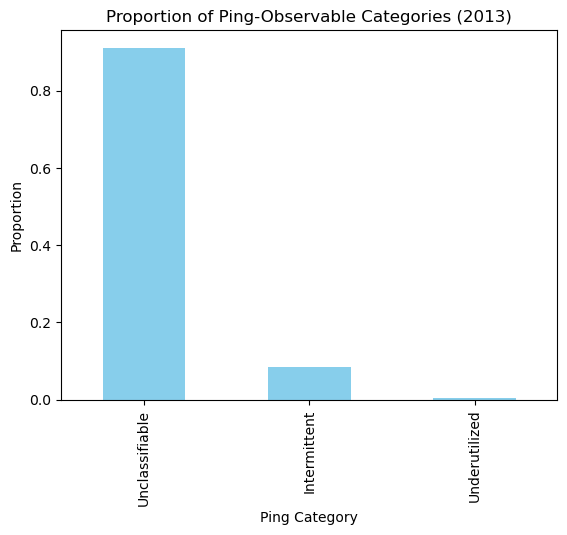

In [32]:
category_proportions_2013.plot(kind='bar', color='skyblue')
plt.title("Proportion of Ping-Observable Categories (2013)")
plt.xlabel("Ping Category")
plt.ylabel("Proportion")
plt.show()

### 2023

In [33]:
block_metrics_2023['ping_category'] = block_metrics_2023.apply(classify_block, axis=1)
print("Block-level ping-observable classification for 2023:")
print(block_metrics_2023[['block_24', 'availability', 'volatility', 'median_up', 'ping_category']].head())

Block-level ping-observable classification for 2023:
    block_24  availability  volatility  median_up   ping_category
0  128.10.25      0.000000         0.0        0.0  Unclassifiable
1  128.10.25      0.992063         2.0    46530.0   Always-stable
2  128.10.25      0.000000         0.0        0.0  Unclassifiable
3  128.10.25      0.000000         0.0        0.0  Unclassifiable
4  128.10.25      0.000000         0.0        0.0  Unclassifiable


In [34]:
category_counts_2023 = block_metrics_2023['ping_category'].value_counts()
print("Counts per category:")
print(category_counts_2023)

Counts per category:
ping_category
Unclassifiable      159811
Always-stable         4276
Intermittent           398
Underutilized           84
Sometimes-stable        37
Name: count, dtype: int64


In [35]:
category_proportions_2023 = block_metrics_2023['ping_category'].value_counts(normalize=True)
print("\nProportions per category:")
print(category_proportions_2023)


Proportions per category:
ping_category
Unclassifiable      0.970870
Always-stable       0.025977
Intermittent        0.002418
Underutilized       0.000510
Sometimes-stable    0.000225
Name: proportion, dtype: float64


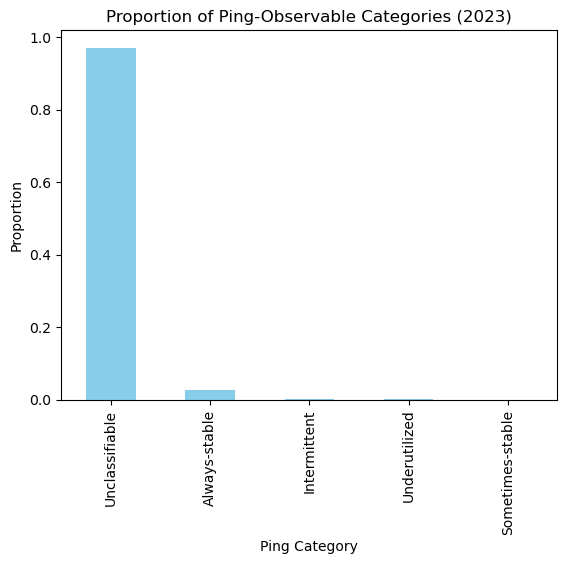

In [36]:
category_proportions_2023.plot(kind='bar', color='skyblue')
plt.title("Proportion of Ping-Observable Categories (2023)")
plt.xlabel("Ping Category")
plt.ylabel("Proportion")
plt.show()

## ML

In [37]:
def classify_blocks_ml(blocks_df):
    """
    Classify blocks entirely via clustering (ML-based) for blocks with availability >= 0.2.
    Blocks with availability < 0.2 are labeled as 'inactive'.
    
    The active blocks are clustered into 4 groups using all three features:
       - availability (as a fraction, 0–1)
       - volatility
       - median_up (in seconds)
    
    After clustering, we automatically assign provisional labels based on the 
    cluster centers. For example, the cluster with the highest average availability 
    may be interpreted as "always-active" and the one with the lowest as "underutilized".
    
    Parameters:
       blocks_df: DataFrame containing block-level metrics with columns:
          'availability', 'volatility', 'median_up', and (optionally) others.
    
    Returns:
       all_classified: DataFrame with an added 'category' column.
       centers: DataFrame of the cluster centers (in original feature space).
    """
    active_blocks = blocks_df[blocks_df['availability'] >= 0.2].copy()
    inactive_blocks = blocks_df[blocks_df['availability'] < 0.2].copy()
    inactive_blocks['category'] = 'unclassifiable'
    
    X = active_blocks[['availability', 'volatility', 'median_up']].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=4, random_state=6)
    active_blocks['cluster_id'] = kmeans.fit_predict(X_scaled)
    
    centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=['availability', 'volatility', 'median_up']
    )
    
    mapping = {}
    
    sorted_by_avail = centers.sort_values(by='availability', ascending=False)
    mapping[sorted_by_avail.index[0]] = 'always-active'
    mapping[sorted_by_avail.index[-1]] = 'underutilized'
    
    overall_median_up = active_blocks['median_up'].median()
    for cid in sorted_by_avail.index[1:-1]:
        if centers.loc[cid, 'median_up'] >= overall_median_up:
            mapping[cid] = 'sometimes-active'
        else:
            mapping[cid] = 'intermittent'
    
    active_blocks['category'] = active_blocks['cluster_id'].map(mapping)

    all_classified = pd.concat([active_blocks, inactive_blocks])
    
    return all_classified, centers

Automatically assign provisional labels based on cluster centers.
One simple approach is:
- Cluster with highest availability → "always-active"
- Cluster with lowest availability → "underutilized"
- For the two remaining clusters, use the median_up value:
  - If median_up is high (≥ median of all active blocks), label as "sometimes-active"
  - Otherwise, label as "intermittent"

### 2013

In [38]:
classified_blocks_2013, centers_2013 = classify_blocks_ml(block_metrics_2013)
print("Classified 2013 Blocks:")
print(classified_blocks_2013[['probe_addr', 'availability', 'volatility', 'median_up', 'original_block', 'final_block_size', 'category']].head())

Classified 2013 Blocks:
      probe_addr  availability  volatility  median_up original_block  \
23   128.10.25.4      0.780303        14.0     1979.5      128.10.25   
26   128.10.25.7      0.780303        14.0     1979.0      128.10.25   
28   128.10.25.9      0.689394        22.0     1320.0      128.10.25   
32  128.10.25.13      0.742424        18.0     1650.0      128.10.25   
59  128.10.25.40      0.765152        15.0     1320.0      128.10.25   

    final_block_size      category  
23               256  intermittent  
26               256  intermittent  
28               256  intermittent  
32               256  intermittent  
59               256  intermittent  


In [39]:
print(classified_blocks_2013['category'].value_counts(normalize=True))

category
unclassifiable    0.917528
intermittent      0.059626
always-active     0.018853
underutilized     0.003992
Name: proportion, dtype: float64


### 2023

In [40]:
classified_blocks_2023, centers_2023 = classify_blocks_ml(block_metrics_2023)
print("Classified 2023 Blocks:")
print(classified_blocks_2023[['probe_addr', 'availability', 'volatility', 'median_up', 'original_block', 'final_block_size', 'category']].head())

Classified 2023 Blocks:
        probe_addr  availability  volatility  median_up original_block  \
1      128.10.25.1      0.992063         2.0    46530.0      128.10.25   
14    128.10.25.14      1.000000         1.0    94380.0      128.10.25   
100  128.10.25.100      1.000000         1.0    94380.0      128.10.25   
101  128.10.25.101      0.992063         2.0    46530.0      128.10.25   
102  128.10.25.102      1.000000         1.0    94380.0      128.10.25   

     final_block_size       category  
1                 256   intermittent  
14                256  always-active  
100               256  always-active  
101               256   intermittent  
102               256  always-active  


In [41]:
print(classified_blocks_2023['category'].value_counts(normalize=True))

category
unclassifiable    0.971483
always-active     0.015455
intermittent      0.012752
underutilized     0.000310
Name: proportion, dtype: float64
